In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Load dataset
df = pd.read_csv("hourly_load.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour

# Filter October 2024
df_oct = df[(df['datetime'].dt.year == 2024) & (df['datetime'].dt.month == 10)].copy()

# KMEANS CLUSTERING FOR LOAD
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_oct['cluster'] = kmeans.fit_predict(df_oct[['load']])

# Sort cluster labels by load magnitude
centers = kmeans.cluster_centers_.flatten()
order = np.argsort(centers)

mapping = {
    order[0]: 'Low',
    order[1]: 'Medium',
    order[2]: 'High'
}

df_oct['load_class'] = df_oct['cluster'].map(mapping)

# ASSIGN DYNAMIC TARIFF BASED ON CLASS
def dynamic_tariff(category):
    if category == 'Low':
        return 5000
    elif category == 'Medium':
        return 7000
    else:
        return 10000

df_oct['dynamic_tariff'] = df_oct['load_class'].apply(dynamic_tariff)
df_oct['dynamic_cost'] = df_oct['dynamic_tariff'] * df_oct['load']

print(df_oct[['datetime', 'load', 'load_class', 'dynamic_tariff', 'dynamic_cost']].head())


                 datetime         load load_class  dynamic_tariff  \
56622 2024-10-01 00:00:00  5408.660000       High           10000   
56623 2024-10-01 01:00:00  5098.861667       High           10000   
56624 2024-10-01 02:00:00  4860.904167     Medium            7000   
56625 2024-10-01 03:00:00  4612.750833     Medium            7000   
56626 2024-10-01 04:00:00  4390.986667     Medium            7000   

       dynamic_cost  
56622  5.408660e+07  
56623  5.098862e+07  
56624  3.402633e+07  
56625  3.228926e+07  
56626  3.073691e+07  


In [15]:
# FLAT TARIFF (₹/MWh)
FLAT_PRICE = 7500  # ₹7.5/kWh = ₹7500/MWh

# Cost under flat pricing
df_oct['flat_cost'] = df_oct['load'] * FLAT_PRICE

# COST UNDER DYNAMIC PRICING
df_oct['dynamic_cost'] = df_oct['load'] * df_oct['dynamic_tariff']

# Total values
flat_total = df_oct['flat_cost'].sum()
dynamic_total = df_oct['dynamic_cost'].sum()
total_profit = flat_total-dynamic_total
print("Total Cost (Flat): ₹{:,.2f}".format(flat_total))
print("Total Cost (Dynamic): ₹{:,.2f}".format(dynamic_total))
print("Total Profits: ₹{:,.2f}".format(total_profit))


Total Cost (Flat): ₹22,269,336,937.50
Total Cost (Dynamic): ₹20,908,103,947.50
Total Profits: ₹1,361,232,990.00


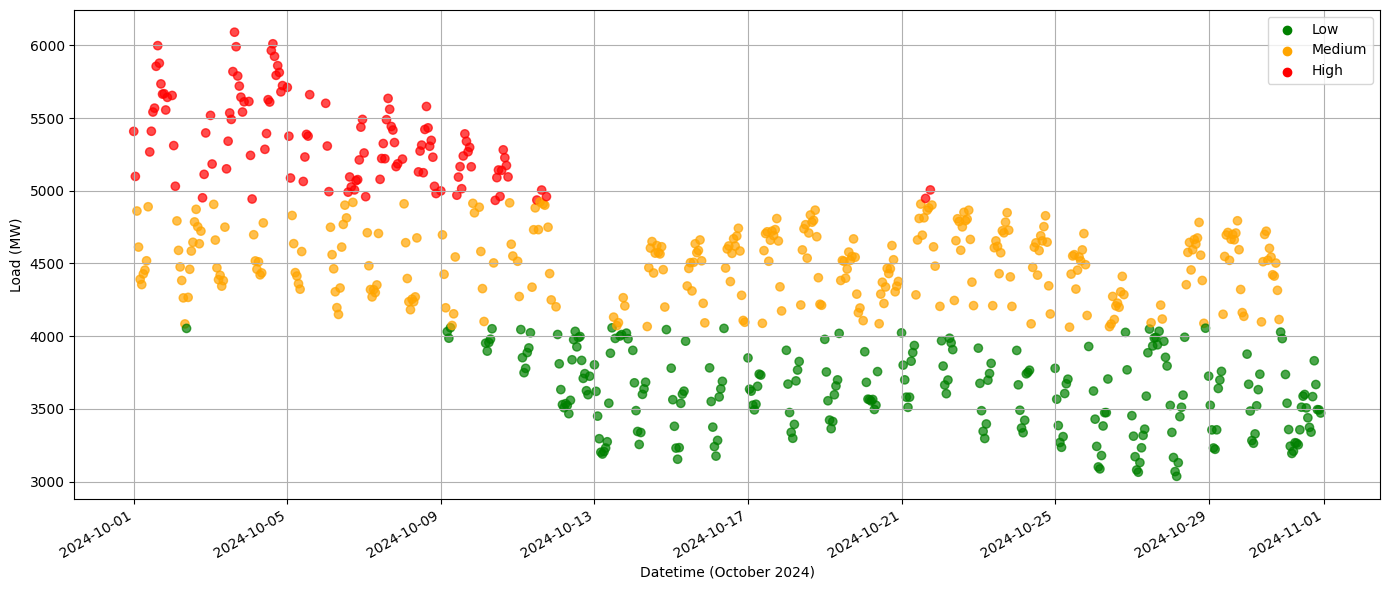

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))

colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}

plt.scatter(
    df_oct['datetime'],
    df_oct['load'],
    c=df_oct['load_class'].map(colors),
    label=None,
    alpha=0.7
)

# Legend
for label, color in colors.items():
    plt.scatter([], [], color=color, label=label)

plt.xlabel("Datetime (October 2024)")
plt.ylabel("Load (MW)")

plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


/tmp/ipython-input-3620882511.py:11: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(x, y_flat, '-', label='Flat Cost (₹7500/MWh)', alpha=0.7)
/tmp/ipython-input-3620882511.py:12: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(x, y_dynamic, '-', label='Dynamic Cost', linewidth=1.2)


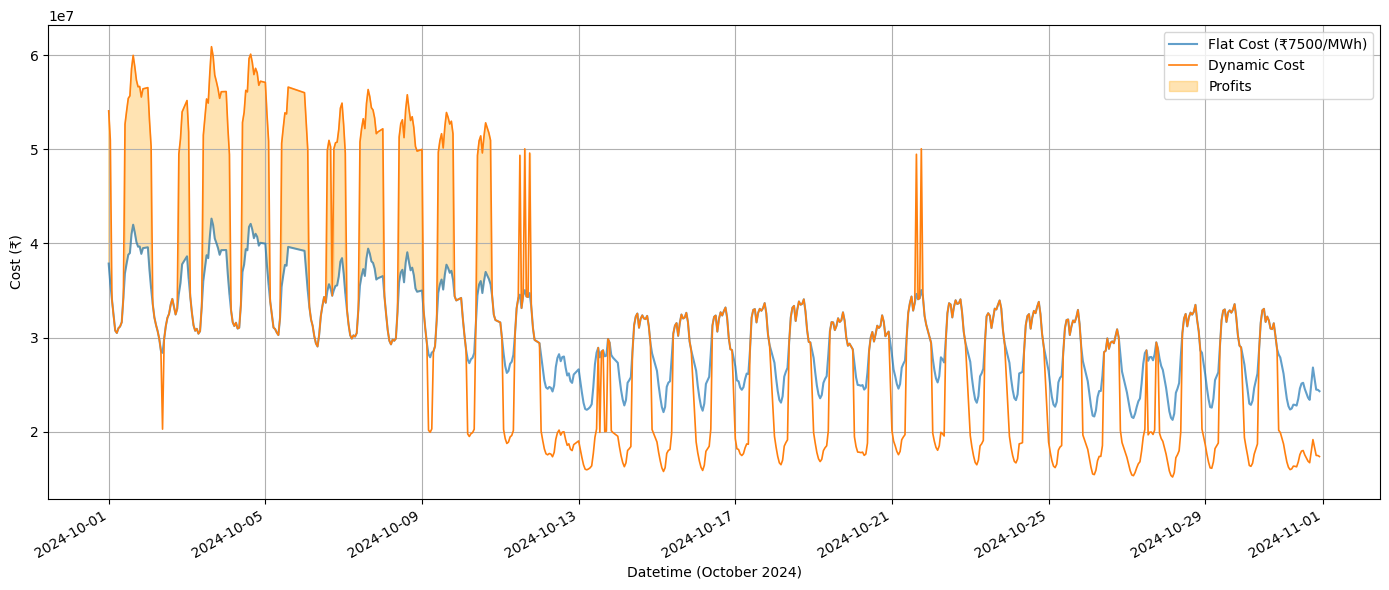

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

x = mdates.date2num(df_oct['datetime'].values)
y_flat = df_oct['load'] * 7000
y_dynamic = df_oct['dynamic_cost']

mask = y_dynamic > y_flat

plt.figure(figsize=(14, 6))
plt.plot_date(x, y_flat, '-', label='Flat Cost (₹7500/MWh)', alpha=0.7)
plt.plot_date(x, y_dynamic, '-', label='Dynamic Cost', linewidth=1.2)

plt.fill_between(
    x, y_dynamic, y_flat,
    where=mask,
    color='orange', alpha=0.3,
    label='Profits'
)

plt.xlabel("Datetime (October 2024)")
plt.ylabel("Cost (₹)")
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


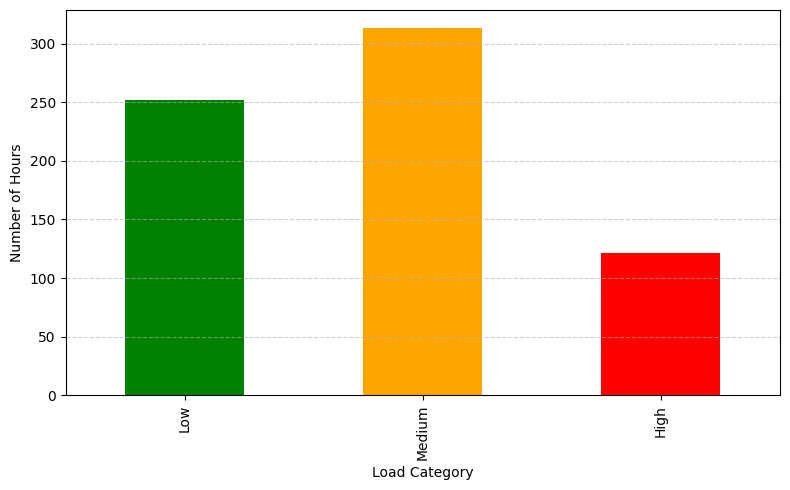

In [20]:
plt.figure(figsize=(8, 5))

df_oct['load_class'].value_counts().loc[['Low','Medium','High']].plot(
    kind='bar',
    color=['green','orange','red']
)

plt.xlabel("Load Category")
plt.ylabel("Number of Hours")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
